In [1]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from matplotlib import animation
from IPython.display import HTML
import matplotlib
from scipy.interpolate import interp1d
from scipy import interpolate

In [2]:
traj = md.load_xtc('405ns_mol.xtc', top = 'pro_mb.gro')
xyz = traj.xyz
top = traj.topology
table, bonds = top.to_dataframe()

In [3]:
table_pro = table[table.resName != 'DPPC']
xyz_pro = xyz[:,table.resName != 'DPPC',:]

In [4]:
start_serial = (table_pro[(table_pro.resSeq==1) & (table_pro.name=='N')].values)[:,0]
end_serial = np.append((start_serial[1:]-1),table_pro.iloc[-1].serial)
for i in range(6):
    table_pro.loc[(start_serial[i]<=table_pro.serial) & (table_pro.serial<=end_serial[i]), 'chainID'] = i+1


/Users/ruisu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
for i in range(3):
    table_pro.loc[(start_serial[i]<=table_pro.serial) & (table_pro.serial<=end_serial[i]), 'resSeq'] += 815
for i in range(3):
    table_pro.loc[(start_serial[i+3]<=table_pro.serial) & (table_pro.serial<=end_serial[i+3]), 'resSeq'] += 685

In [6]:
table_pro

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,816,SER,1,
1,2,H,H,816,SER,1,
2,3,H2,H,816,SER,1,
3,4,H3,H,816,SER,1,
4,5,CA,C,816,SER,1,
...,...,...,...,...,...,...,...
27043,27044,HH21,H,815,ARG,6,
27044,27045,HH22,H,815,ARG,6,
27045,27046,C,C,815,ARG,6,
27046,27047,O,O,815,ARG,6,


In [7]:
def deal_pbc():
    global xyz_pro, table_pro, traj
    
    chain1_center = np.mean(xyz_pro[:,table_pro.chainID==0,:],axis=1)
    chain2_center = np.mean(xyz_pro[:,table_pro.chainID==1,:],axis=1)
    chain3_center = np.mean(xyz_pro[:,table_pro.chainID==2,:],axis=1)

    for j in range(3):
        pbc_cross_1 = np.where(abs(chain1_center[:,j] - chain2_center[:,j])>4)
        for i in range(len(pbc_cross_1[0])):
            if(chain2_center[pbc_cross_1[0][i],j] - chain1_center[pbc_cross_1[0][i],j] > 0):
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] - traj.unitcell_lengths[pbc_cross_1[0][i],j]
            else:
                xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] = xyz_pro[pbc_cross_1[0][i],table_pro.chainID==1,j] + traj.unitcell_lengths[pbc_cross_1[0][i],j]

        pbc_cross_2 = np.where(abs(chain1_center[:,j] - chain3_center[:,j])>4)
        for i in range(len(pbc_cross_2[0])):
            if(chain3_center[pbc_cross_2[0][i],j] - chain1_center[pbc_cross_2[0][i],j] > 0):
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] - traj.unitcell_lengths[pbc_cross_2[0][i],j]
            else:
                xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] = xyz_pro[pbc_cross_2[0][i],table_pro.chainID==2,j] + traj.unitcell_lengths[pbc_cross_2[0][i],j]
    
    return xyz_pro


In [8]:
def read_traj_aa():
    
    #global traj, xyz_pro, table_pro, table
    #xyz_pro = deal_pbc()
    
    loc_start = 0
    
    xyz_fp = xyz_pro[loc_start:,(table_pro.resSeq==816)&(table_pro.name=='CA'),:]
    xyz_tm = np.mean(xyz_pro[loc_start:,(table_pro.resSeq==1214)&(table_pro.name=='CA'),:],axis=1)
    xyz_tm2 = np.mean(xyz_pro[loc_start:,(table_pro.resSeq==1237)&(table_pro.name=='CA'),:],axis=1)
    
    reach = (np.linalg.norm((xyz_fp - xyz_tm[:,np.newaxis,:]), axis=2)).ravel()
    v1 = xyz_tm - xyz_tm2
    v2 = xyz_fp - xyz_tm2[:,np.newaxis,:]
    
    angle = np.zeros(np.shape(reach))
    count = 0
    for i in range(np.shape(v1)[0]):
        for j in range(3):
            v_fp = v2[i,j,:]
            v_tm = v1[i,:]
            angle[count] = np.arccos(np.dot(v_fp,v_tm)/np.linalg.norm(v_fp)/np.linalg.norm(v_tm)) / np.pi * 180
            count = count + 1
    
    pos_temp = xyz_fp - xyz_tm[:,np.newaxis,:]
    pos = pos_temp.reshape((np.shape(pos_temp)[0]*np.shape(pos_temp)[1],3))
    
    return reach, angle, pos

In [9]:
reach_aa, angle_aa, pos_aa  = read_traj_aa()

In [11]:
plt.rcParams['font.family'] = "Helvetica"
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

Text(0, 0.5, 'pdf')

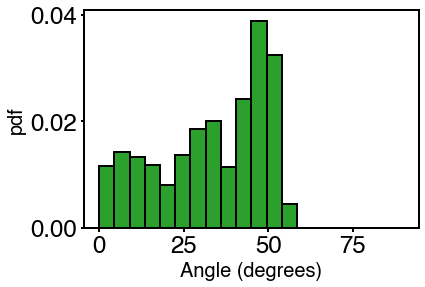

In [12]:
n, bins, patches = plt.hist(angle_aa.ravel(),bins=np.linspace(0,90,21), density=True, facecolor='tab:green',edgecolor='k',linewidth=2)
plt.xlabel('Angle (degrees)')
plt.ylabel('pdf')

[]

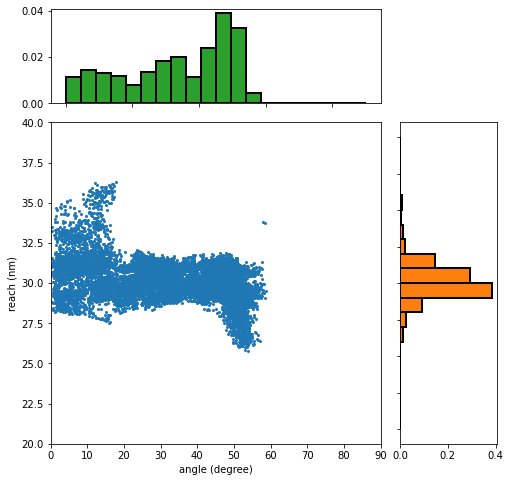

In [105]:
fig = plt.figure(figsize=(8,8))
from matplotlib.gridspec import GridSpec
gs = GridSpec(4,4)

scatter_axes = fig.add_subplot(gs[1:4,0:3])
x_hist_axes = fig.add_subplot(gs[0,0:3])
y_hist_axes = fig.add_subplot(gs[1:4,3])



scatter_axes.plot(angle_aa.ravel(), reach_aa.ravel(), 'o',ms=2)
scatter_axes.set_xlim(0,90)
scatter_axes.set_ylim(20,40)
scatter_axes.set_xlabel('angle (degree)')
scatter_axes.set_ylabel('reach (nm)')

n, bins, patches = x_hist_axes.hist(angle_aa.ravel(),bins=np.linspace(0,90,21), density=True, facecolor='tab:green',edgecolor='k',linewidth=2)
x_hist_axes.set_xticklabels([])


n, bins, patches = y_hist_axes.hist(reach_aa.ravel(),bins=np.linspace(20,40,21), density=True, facecolor='tab:orange',edgecolor='k', orientation='horizontal',linewidth=2)
y_hist_axes.set_yticklabels([])

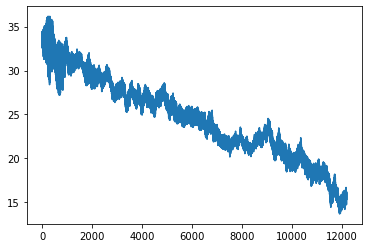

In [108]:
plt.plot(pos_aa[:,2])

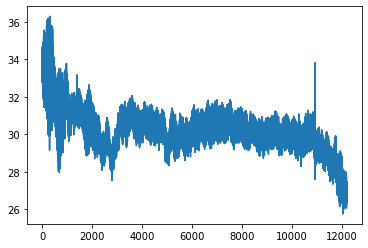